In [1]:
!pip install einops
!pip install timm

     -------------------------------------- 41.6/41.6 kB 666.5 kB/s eta 0:00:00
     ------------------------------------ 549.1/549.1 kB 485.9 kB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 486.2 kB/s eta 0:00:00
     ------------------------------------ 200.1/200.1 kB 450.0 kB/s eta 0:00:00
     ------------------------------------ 172.3/172.3 MB 459.4 kB/s eta 0:00:00
     ------------------------------------ 151.7/151.7 kB 533.6 kB/s eta 0:00:00
     ---------------------------------------- 6.5/6.5 MB 483.6 kB/s eta 0:00:00
     ------------------------------------ 536.2/536.2 kB 487.9 kB/s eta 0:00:00


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Python310\\share'
Consider using the `--user` option or check the permissions.



In [1]:
import tensorflow as tf
import cv2
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

import timm
import torch.nn as nn
import torch

C:\Users\ISHITA\AppData\Local\Temp\ipykernel_8064\802780556.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
C:\Users\ISHITA\AppData\Roaming\Python\Python310\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  device: torch.device = torch.device("cpu"),


In [2]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    return strategy

strategy = auto_select_accelerator()
REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE



IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

class SampleDataset:
    def __init__(self, config, batch_size):
        self.img_size = config.IMAGE_SIZE
        self.batch_size = batch_size


    
    def decode_image(self, image_data):
        image = tf.io.decode_raw(image_data, tf.uint8)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, [self.img_size, self.img_size])   
#         image = tf.stack([image, image, image], axis=-1)
        
        return image

    
    def read_labeled_tfrecord(self, example):

        tfrec_format={
                    'label_normal': tf.io.FixedLenFeature([], tf.int64),
                    'image': tf.io.FixedLenFeature([], tf.string)
                }
        example = tf.io.parse_single_example(
                example, tfrec_format)

                
            
            # now return the converted data
        label = example['label_normal']
        image = self.decode_image(example["image"])
        
        return {"input": image}, {"target": label}


    # This function loads TF Records and parse them into tensors
    def load_dataset(self, filenames, cache=False, repeat=False, shuffle=False):        
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
        if cache:
            dataset = dataset.cache()

        if shuffle:
            dataset = dataset.shuffle(2048)
            opt = tf.data.Options()
            opt.experimental_deterministic = False
            dataset = dataset.with_options(opt)

        dataset = dataset.map(self.read_labeled_tfrecord, num_parallel_calls = AUTO) 
        if repeat:
            dataset = dataset.repeat()
        dataset = dataset.batch(self.batch_size * REPLICAS)
        dataset = dataset.prefetch(AUTO)
        return dataset
    
    
class TFRecordDataLoader:
    def __init__(self, files, config, batch_size=32, cache=False, train=True, repeat=False, shuffle=False, labeled=True, return_image_ids=True):
        sample_dataset = SampleDataset(config, batch_size=batch_size)
        self.ds = sample_dataset.load_dataset(files)
        
        if train:
            self.num_examples = len(files)*11177
        else:
            self.num_examples = len(files)*11177

        self.batch_size = batch_size
        self.labeled = labeled
        self.return_image_ids = return_image_ids
        self._iterator1 = None
    
    def __next__(self):
        batch = next(self._iterator1)
        batch = self.process_batch(batch)
        return batch
    
    
    def __iter__(self):
        if self._iterator1 is None:
            self._iterator1 = iter(self.ds)
        else:
            self._reset()
        return self._iterator1

    def _reset(self):
        self._iterator1 = iter(self.ds)




    def __len__(self):
        n_batches = self.num_examples // self.batch_size
        if self.num_examples % self.batch_size == 0:
            return n_batches
        else:
            return n_batches + 1
        
    @staticmethod
    def process_batch(batch, device):
        image_torch = torch.from_numpy(batch[0]['input'].numpy())
        image_torch =  repeat(image_torch, 'b h w -> b c h w', c=1)
        
        label = torch.from_numpy(batch[1]['target'].numpy()).long()
        image_torch = image_torch.to(device)
        label = label.to(device)
        return {"input": image_torch}, {"target": label}
    
    
# visualize
def display_images(images, labels): 

    f, ax = plt.subplots(4,4, figsize=(18,22))

    for i, image_id in enumerate(images[:16]):
        image = images[i]
        label = labels[i]
        ax[i//4, i%4].imshow(image, cmap='gray') 
        ax[i//4, i%4].axis('off')

        ax[i//4, i%4].set_title(f"Class: {label}")

    plt.show() 


Running on 1 replicas


# training

In [10]:
# experiment with 2 tfrecord samples

tfrecords = ['training10_0/training10_0.tfrecords',
 'training10_1/training10_1.tfrecords']

In [4]:
class Config:
    NUM_EPOCH = 1
    BATCH_SIZE = 16
    IMAGE_SIZE = 299
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
class AverageMeter:
    ''' Computes and stores the average and current value '''
    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def get_accuracy(labels, outputs):
    _, predicted = torch.max(outputs, 1)
    return (labels == predicted).sum()/labels.shape[0]


In [11]:
class SampleTrainer():
    def __init__(self, model, train_dataloader, valid_dataloader, optimizer, criterion, config) -> None:
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = config.DEVICE
        self.num_epoch = config.NUM_EPOCH
        self.model = model

    def train_one_epoch(self):
        self.model.train()
        losses = AverageMeter()
        avg_score = AverageMeter()
        tk0 = tqdm(self.train_dataloader, total=len(self.train_dataloader))
        for i, batch in enumerate(tk0, 0):
            batch_processed = self.train_dataloader.process_batch(batch, self.device)
            inputs = batch_processed[0]['input']
            labels = batch_processed[1]['target']
            

            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            batch_score = get_accuracy(labels, outputs.detach()).data.item()
            avg_score.update(batch_score, inputs.shape[0])
            losses.update(loss.data.item(), inputs.shape[0])
            loss.backward()
            self.optimizer.step()
            
            tk0.set_postfix(loss=losses.avg, avg_score=avg_score.avg)

    def eval_one_epoch(self):
        self.model.eval()
        losses = AverageMeter()
        avg_score = AverageMeter()
        tk0 = tqdm(self.valid_dataloader, total=len(self.valid_dataloader))
        with torch.no_grad():
            for i, batch in enumerate(tk0, 0):
                batch_processed = self.process_batch_valid(batch)
                inputs = batch_processed[0]['input']
                labels = batch_processed[1]['target']
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                batch_score = get_accuracy(labels, outputs.detach()).data.item()
                avg_score.update(batch_score, inputs.shape[0])
                losses.update(loss.data.item(), inputs.shape[0])
                
                tk0.set_postfix(eval_loss=losses.avg, eval_avg_score=avg_score.avg)


    def process_batch_valid(self, batch):
        images = batch[0]['input']
        labels = batch[1]['target']
        images = rearrange(images, "b h w c -> b c h w")
        images = images.to(self.device)
        labels = labels.to(self.device)

        return {"input": images}, {"target": labels}

    def train(self):
        self.model.to(self.device)
        for epoch in range(self.num_epoch):
            print(f"Training {epoch}")
            self.train_one_epoch()
            print(f"Eval epoch {epoch}")
            self.eval_one_epoch()


In [12]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=5, in_chans=1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_dataloader = TFRecordDataLoader(files=tfrecords, config=Config, batch_size=Config.BATCH_SIZE)

# valid dataloader
valid_images = np.load("cv10_data/cv10_data.npy")
valid_labels = np.load("cv10_labels.npy")


valid_images = torch.Tensor(valid_images)
valid_labels = torch.Tensor(valid_labels)

valid_dataset = TensorDataset(valid_images, valid_labels)

def collate_valid_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    targets = torch.stack(targets).long()
    return {"input": images}, {"target": targets}

valid_dataloader = DataLoader(valid_dataset, batch_size=Config.BATCH_SIZE, collate_fn=collate_valid_fn)

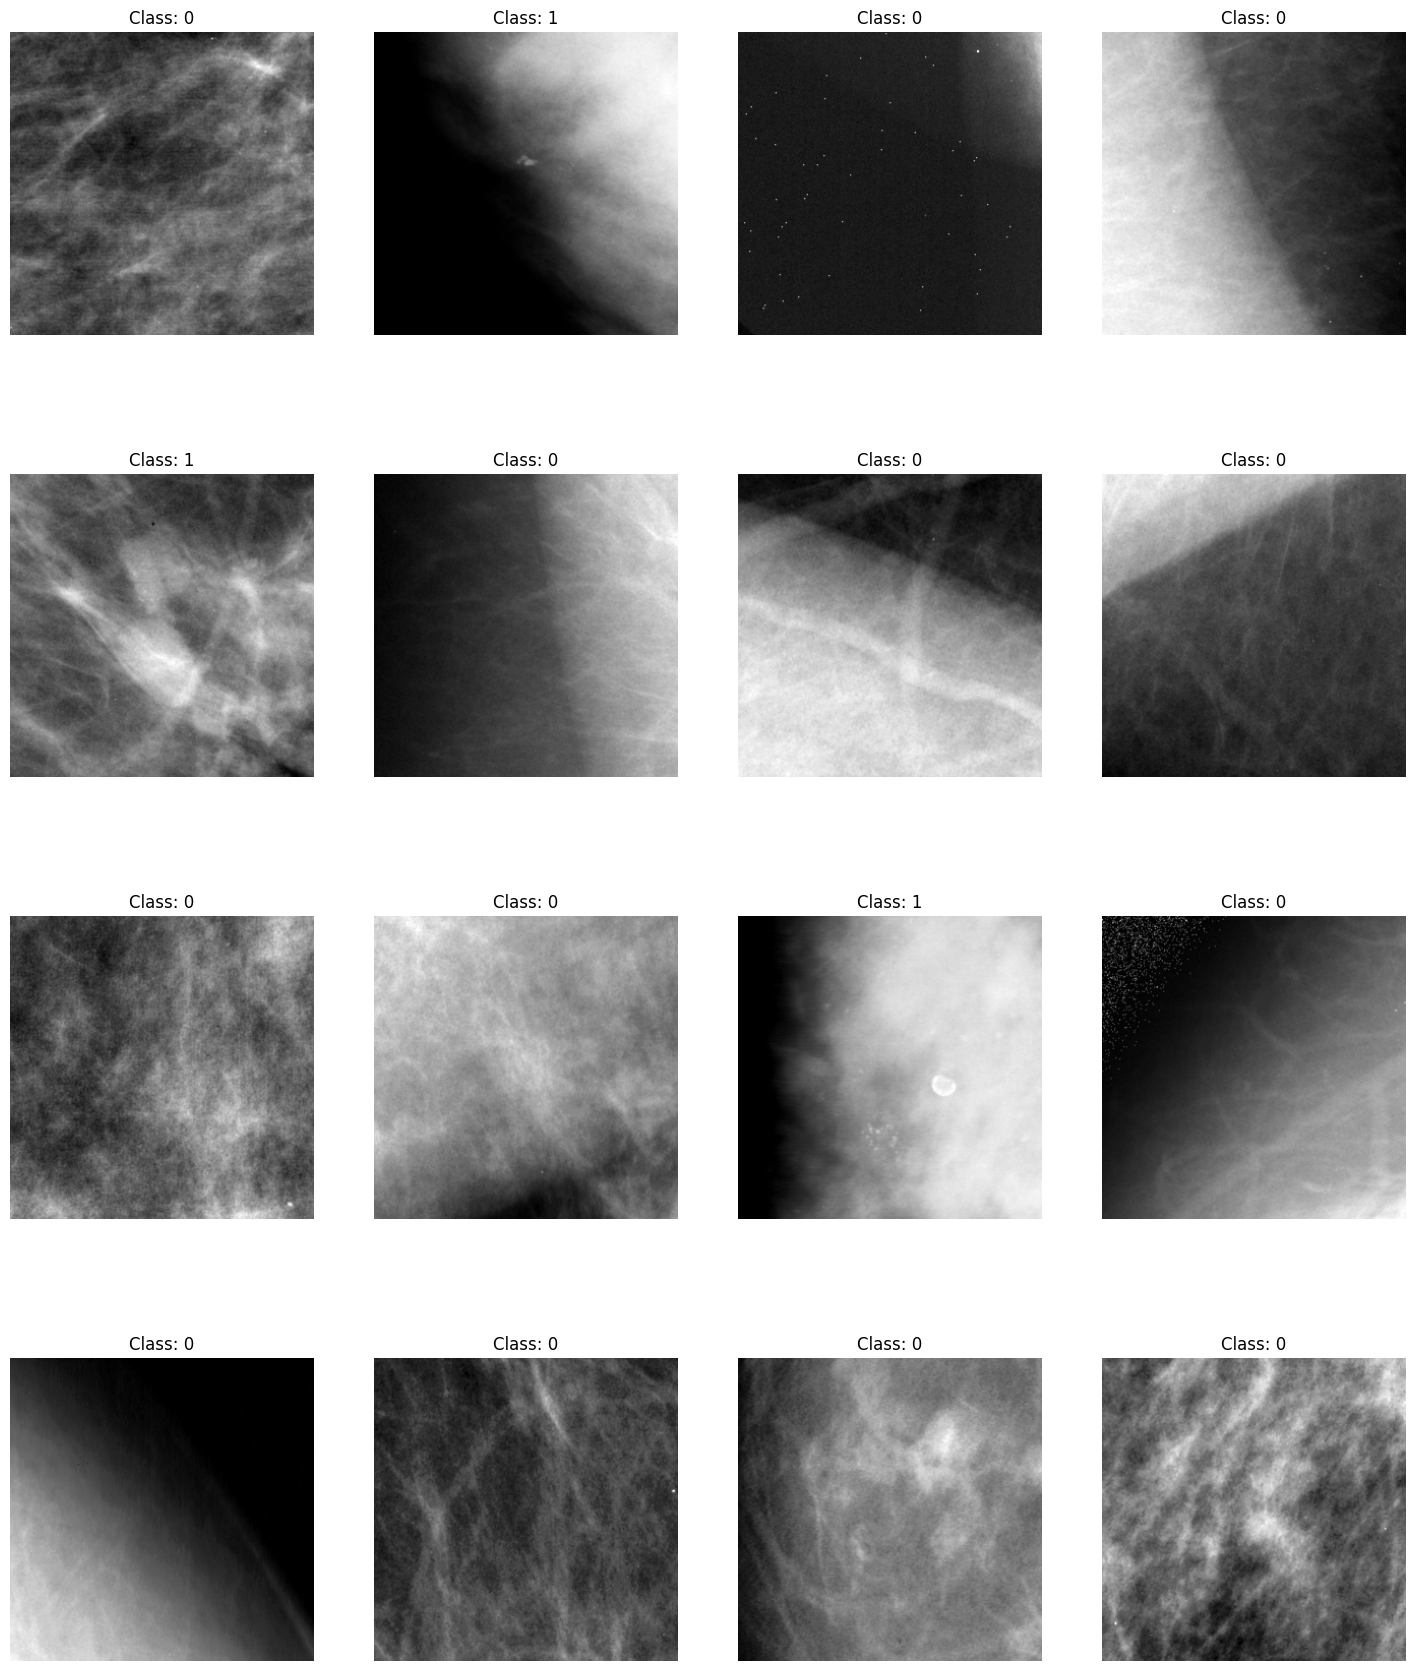

In [13]:
def get_sample_batch():
    sample_ind = np.random.randint(0, 100)
    for i, batch in enumerate(train_dataloader):
        if i == sample_ind:
            break
    return batch

batch = get_sample_batch()
images = batch[0]['input'].numpy()
labels = batch[1]['target'].numpy()
display_images(images, labels)

In [14]:
def display_images(images,TRAIN_IMAGE_DIR,  title=None): 
    """
    func for display images
    """
    f, ax = plt.subplots(5,5, figsize=(18,22))
    if title:
        f.suptitle(title, fontsize = 30)

    for i, image_id in enumerate(images):
        image_path = os.path.join(TRAIN_IMAGE_DIR, f'{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.jpg')
        image = Image.open(image_path)
        
        ax[i//5, i%5].imshow(image) 
        image.close()       
        ax[i//5, i%5].axis('off')

        landmark_id = train[train.id==image_id.split('.')[0]].landmark_id.values[0]
        ax[i//5, i%5].set_title(f"ID: {image_id.split('.')[0]}\nLandmark_id: {landmark_id}", fontsize="12")

    plt.show() 

In [15]:
sample_trainer = SampleTrainer(model=model, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, optimizer=optimizer, criterion=criterion, config=Config)

In [18]:
sample_trainer.train()

Training 0


  0%|          | 0/1398 [00:00<?, ?it/s]


RuntimeError: Numpy is not available